# MIMIC IV CNN Evaluation

### Set Up 

In [143]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, average_precision_score, precision_recall_curve
from tableone import TableOne

**Column Definitions**
- subject_id: *patient unique identifier*
- study_id: *study of patient (x-ray instance)*
- dicom_id: *individual image ID*
- split: *train-validate-test split*
- path: *image path*
- hadm_id: *hospital admission id*
- admittime: *time of hospital admission*
- dischtime: *time of hospital discharge*
- deathtime: *time of death*
- admission_type: *admission type*
- admission_location: *admission location*
- discharge_location: *discharge location* 
- insurance: *patient's insurance type [Medicaid, Medicare, Other (private)]*
- language: *patient's native language*
- marital_status: *patient's marital status*
- race: *patient's race*
- edregtime: *in time of ER admittance*
- edouttime: *out time of ER admittance*
- hospital_expire_flag: *whether they died or not*
- gender: *patient's gender*
- anchor_age: *age*
- anchor_year: *shifted year by same delta*
- anchor_year_group: *bins of shifted years*
- dod: *death of death*
- Diagonses (values[-1.0, 0.0, 1.0])
    - Atelectasis
    - Cardiomegaly
    - Consolidation
    - Edema
    - Enlarged Cardiomediastinum
    - Fracture
    - Lung Lesion
    - Lung Opacity
    - No Finding
    - Pleural Effusion
    - Pleural Other
    - Pneumonia
    - Pneumothorax
    - Support Devices
- Probability of Diagnosis (0,1)
    - pred_Atelectasis
    - pred_Cardiomegaly
    - pred_Consolidation
    - pred_Edema
    - pred_Enlarged Cardiomediastinum
    - pred_Fracture
    - pred_Lung Lesion
    - pred_Lung Opacity
    - pred_No Finding
    - pred_Pleural Effusion
    - pred_Pleural Other
    - pred_Pneumonia
    - pred_Pneumothorax
    - pred_Support Devices

    

In [3]:
results = pd.read_csv('../runs/run1/results.csv')
admissions = pd.read_csv('/home/zzaiman/local/physionet.org/files/mimiciv/2.0/hosp/admissions.csv')
patients = pd.read_csv('/home/zzaiman/local/physionet.org/files/mimiciv/2.0/hosp/patients.csv')

In [4]:
results = results.merge(admissions, on='subject_id')
results = results.merge(patients, on='subject_id')
results.head()

,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,...,marital_status,race,edregtime,edouttime,hospital_expire_flag,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10032725,50331901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,SINGLE,BLACK/AFRICAN AMERICAN,2143-03-22 01:19:00,2143-03-22 06:42:00,0,F,38,2143,2011 - 2013,2143-03-30
1,10032725,50331901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,SINGLE,BLACK/AFRICAN AMERICAN,2143-02-17 07:19:00,2143-02-17 15:18:00,0,F,38,2143,2011 - 2013,2143-03-30
2,10032725,55504914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,SINGLE,BLACK/AFRICAN AMERICAN,2143-03-22 01:19:00,2143-03-22 06:42:00,0,F,38,2143,2011 - 2013,2143-03-30
3,10032725,55504914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,SINGLE,BLACK/AFRICAN AMERICAN,2143-02-17 07:19:00,2143-02-17 15:18:00,0,F,38,2143,2011 - 2013,2143-03-30
4,10046166,50051329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,MARRIED,WHITE,2132-12-06 09:52:00,2132-12-06 12:56:00,0,M,67,2132,2011 - 2013,2133-11-04


In [5]:
results.columns

Index(['subject_id', 'study_id', 'Atelectasis', 'Cardiomegaly',
       'Consolidation', 'Edema', 'Enlarged Cardiomediastinum', 'Fracture',
       'Lung Lesion', 'Lung Opacity', 'No Finding', 'Pleural Effusion',
       'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices',
       'dicom_id', 'split', 'path', 'pred_Atelectasis', 'pred_Cardiomegaly',
       'pred_Consolidation', 'pred_Edema', 'pred_Enlarged Cardiomediastinum',
       'pred_Fracture', 'pred_Lung Lesion', 'pred_Lung Opacity',
       'pred_No Finding', 'pred_Pleural Effusion', 'pred_Pleural Other',
       'pred_Pneumonia', 'pred_Pneumothorax', 'pred_Support Devices',
       'hadm_id', 'admittime', 'dischtime', 'deathtime', 'admission_type',
       'admission_location', 'discharge_location', 'insurance', 'language',
       'marital_status', 'race', 'edregtime', 'edouttime',
       'hospital_expire_flag', 'gender', 'anchor_age', 'anchor_year',
       'anchor_year_group', 'dod'],
      dtype='object')

### Overall Evaluation

**1. Loss Plots**

Since we are running a multi-class model, we will evaluate our model performance individually on each label. There are multiple ways we can do this. First, we can make loss plots for each label (we are minimizing cross-entropy loss here).

In [144]:
labels = 'Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices'.split(',')
labels = np.array(labels)

In [148]:
preds = pickle.load(open('/local/scratch/zzaiman/CS334FinalProject/zach/runs/run1/predictions', 'rb'))
hist = pickle.load(open('/local/scratch/zzaiman/CS334FinalProject/zach/runs/run1/train_hist', 'rb'))

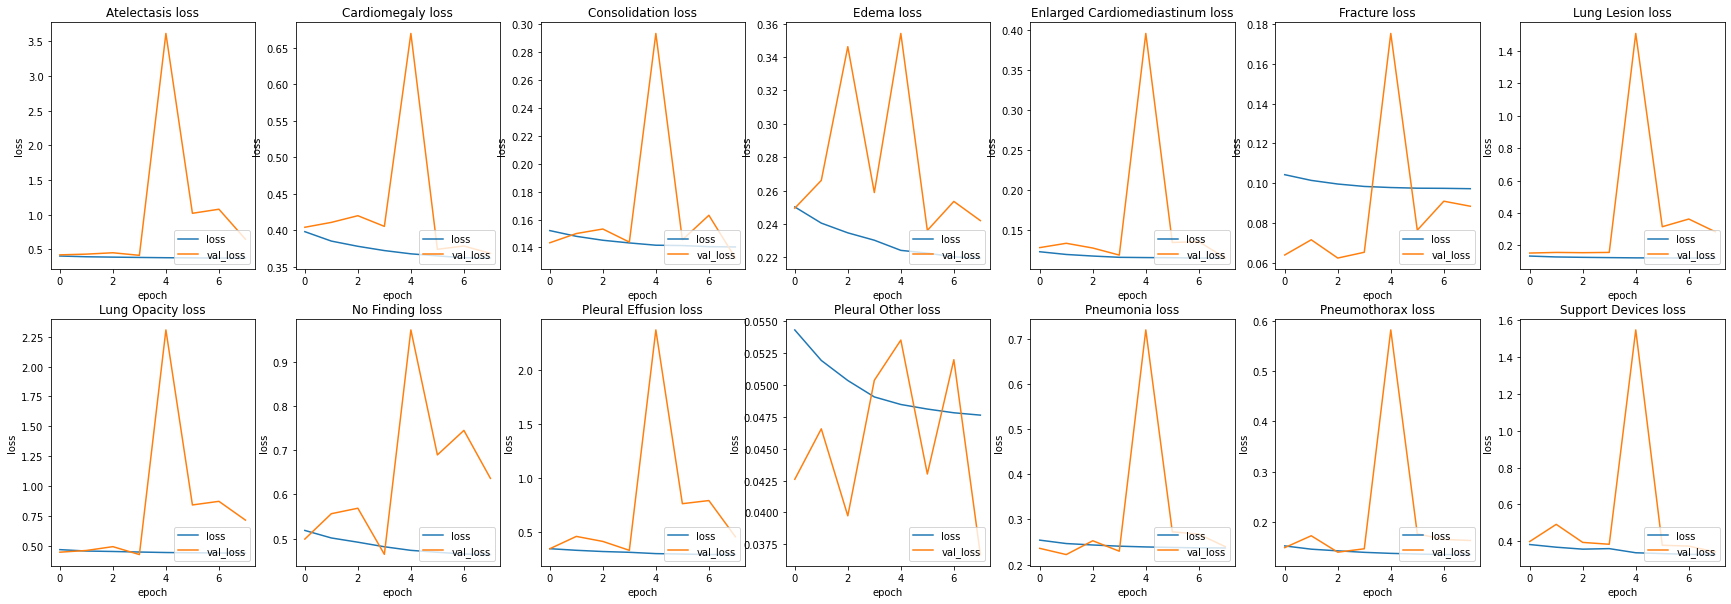

In [150]:
# Loss Plots
fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(30, 10))
for i, lab in enumerate(labels):
    loss = hist[f'dense_{str(i+1)}_loss']
    val_loss = hist[f'val_dense_{str(i+1)}_loss']
    title = f'{lab} loss'

    if i < 7:
        x = 0
    else:
        x = 1
    
    if i < 7:
        y = i
    else:
        y = i - 7

    ax[x, y].plot(loss, label='loss')
    ax[x, y].plot(val_loss, label='val_loss')
    ax[x, y].title.set_text(title)
    ax[x, y].legend(loc=4)
    ax[x, y].set_xlabel('epoch')
    ax[x, y].set_ylabel('loss')

**2. AUROC**

The second way we can assess our model performance is by plotting the AUROC curve for each label. We can find the overall AUC values for each label as well.

In [151]:
# Overall AUCs
fpr = {}
tpr = {}
auc = {}
for lab in labels:
    ytrue = results[lab]
    ypred = results['pred_'+lab]
    tfpr, ttpr, _ = roc_curve(ytrue, ypred)
    tauc = roc_auc_score(ytrue, ypred)
    fpr[lab] = tfpr
    tpr[lab] = ttpr
    auc[lab] = tauc

auc

{'Atelectasis': 0.758114692706031,
 'Cardiomegaly': 0.7529810870115898,
 'Consolidation': 0.6835065038344478,
 'Edema': 0.8090850685796543,
 'Enlarged Cardiomediastinum': 0.6967027504184521,
 'Fracture': 0.6536547528841741,
 'Lung Lesion': 0.6942042533136963,
 'Lung Opacity': 0.6160740880092402,
 'No Finding': 0.7828640060593266,
 'Pleural Effusion': 0.8837569319472338,
 'Pleural Other': 0.7218008659896464,
 'Pneumonia': 0.639516341988684,
 'Pneumothorax': 0.7141561369965268,
 'Support Devices': 0.8433541824671278}

In [153]:
# Function to calculate ROC
def calc_roc(df, labels):

    fpr = {}
    tpr = {}
    auc = {}

    fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(30, 10))
    
    for i, lab in enumerate(labels):
        if i < 7:
            x = 0
        else:
            x = 1
        if i < 7:
            y = i
        else:
            y = i - 7

        otpr, ofpr, _, = roc_curve(df[lab], df['pred_'+lab])
        oauc = roc_auc_score(df[lab], df['pred_'+lab])
        ax[x, y].plot(otpr, ofpr, label=f'Overall auc={round(oauc, 2)}', color='red')
        min = otpr.min()
        ax[x, y].fill_between(otpr,min,ofpr,alpha=0.5, color='red')
        ax[x, y].title.set_text(lab)
        ax[x, y].legend(loc=2)
        ax[x, y].set_xlabel('TPR')
        ax[x, y].set_ylabel('FPR')

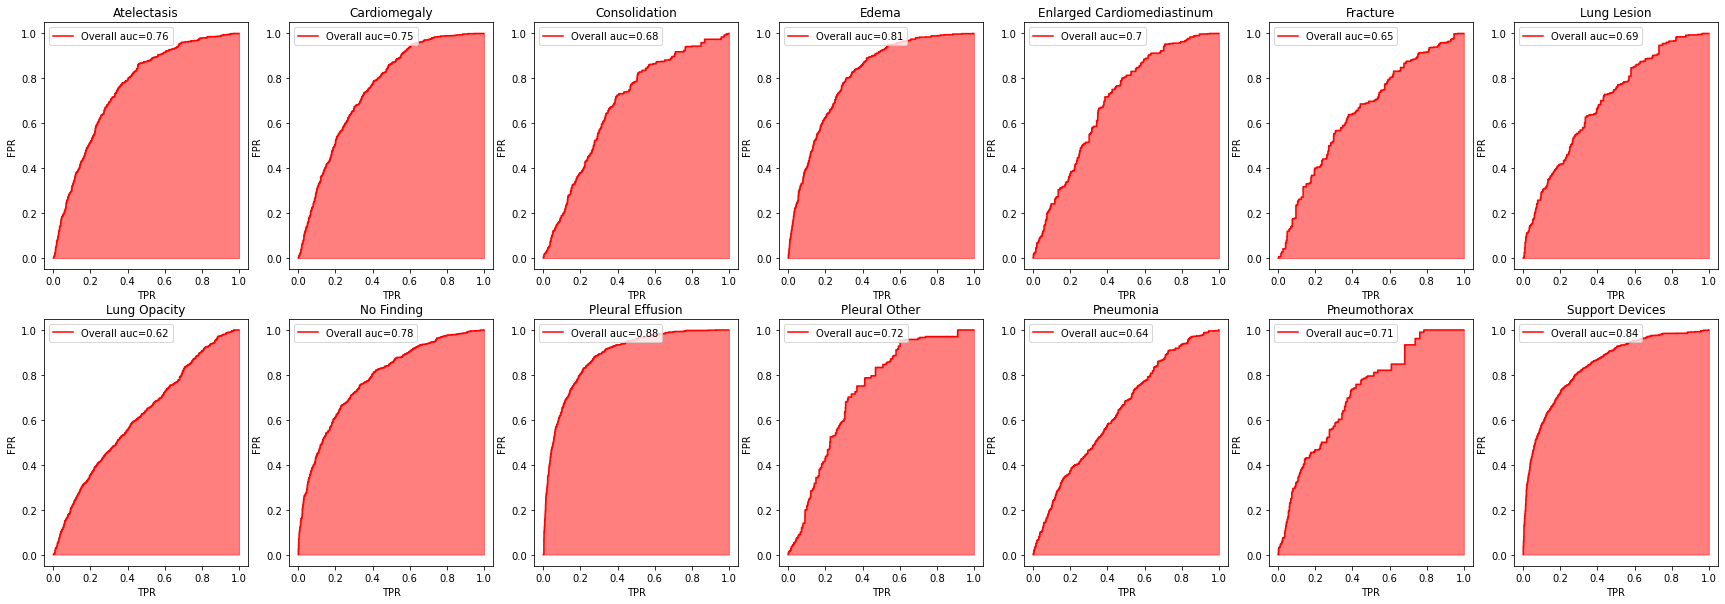

In [154]:
calc_roc(results, labels)

The above AUROC curves and overall AUC scores for each label are relatively high, indicating good model performance. However we know that there is likely a large class imbalance in this dataset, since only a relatively few number of people will have a lung disease in one of these 14 categories. We can confirm this by looking at the class ratios for each diagonsis label.

In [163]:
lab_imb = {}
for lab in labels:
    a = results[lab].value_counts()
    ratio = round(a[1.0]/a[0.0],3)
    lab_imb[lab] = ratio

lab_imb

{'Atelectasis': 0.193,
 'Cardiomegaly': 0.341,
 'Consolidation': 0.057,
 'Edema': 0.264,
 'Enlarged Cardiomediastinum': 0.024,
 'Fracture': 0.023,
 'Lung Lesion': 0.031,
 'Lung Opacity': 0.427,
 'No Finding': 0.277,
 'Pleural Effusion': 0.314,
 'Pleural Other': 0.013,
 'Pneumonia': 0.116,
 'Pneumothorax': 0.012,
 'Support Devices': 0.297}

**3. AUPRC**

As we can see from the above dictionary, there is a large class imbalance in every diagnosis label. This means that it is a good idea to also plot AUPRC curves for each diagnosis, since they tend to be more robust against class imbalance.

In [165]:
# Overall Average Precision Score 
aps_macro = {}
for lab in labels:
    ytrue = results[lab]
    ypred = results['pred_'+lab]
    taps = average_precision_score(ytrue, ypred, average='macro') # weighted and macro provide similar results
    aps_macro[lab] = taps

aps_macro

{'Atelectasis': 0.33285568956280137,
 'Cardiomegaly': 0.44832821158456804,
 'Consolidation': 0.09289797873040367,
 'Edema': 0.5011181934350778,
 'Enlarged Cardiomediastinum': 0.05038345258396595,
 'Fracture': 0.03760437194674607,
 'Lung Lesion': 0.0696292707345563,
 'Lung Opacity': 0.39811236903142705,
 'No Finding': 0.5395533152436942,
 'Pleural Effusion': 0.6943563094902627,
 'Pleural Other': 0.03143656155446775,
 'Pneumonia': 0.17091766051656548,
 'Pneumothorax': 0.030521221410905745,
 'Support Devices': 0.656945488444721}

In [166]:
def calc_auprc(df, labels):

    fpr = {}
    tpr = {}
    auc = {}

    fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(30, 10))
    
    for i, lab in enumerate(labels):
        if i < 7:
            x = 0
        else:
            x = 1
        if i < 7:
            y = i
        else:
            y = i - 7

        opre, orec, _ = precision_recall_curve(df[lab], df['pred_'+lab])
        avg_pre = average_precision_score(df[lab], df['pred_'+lab])
        ax[x, y].plot(orec, opre, label=f'Average Precision={round(avg_pre, 2)}')
        min = opre.min()
        ax[x, y].fill_between(orec,min,opre,alpha=0.5)
        ax[x, y].title.set_text(lab)
        ax[x, y].legend(loc=2)
        ax[x, y].set_xlabel('True Positive Rate (Recall)')
        ax[x, y].set_ylabel('Precision')

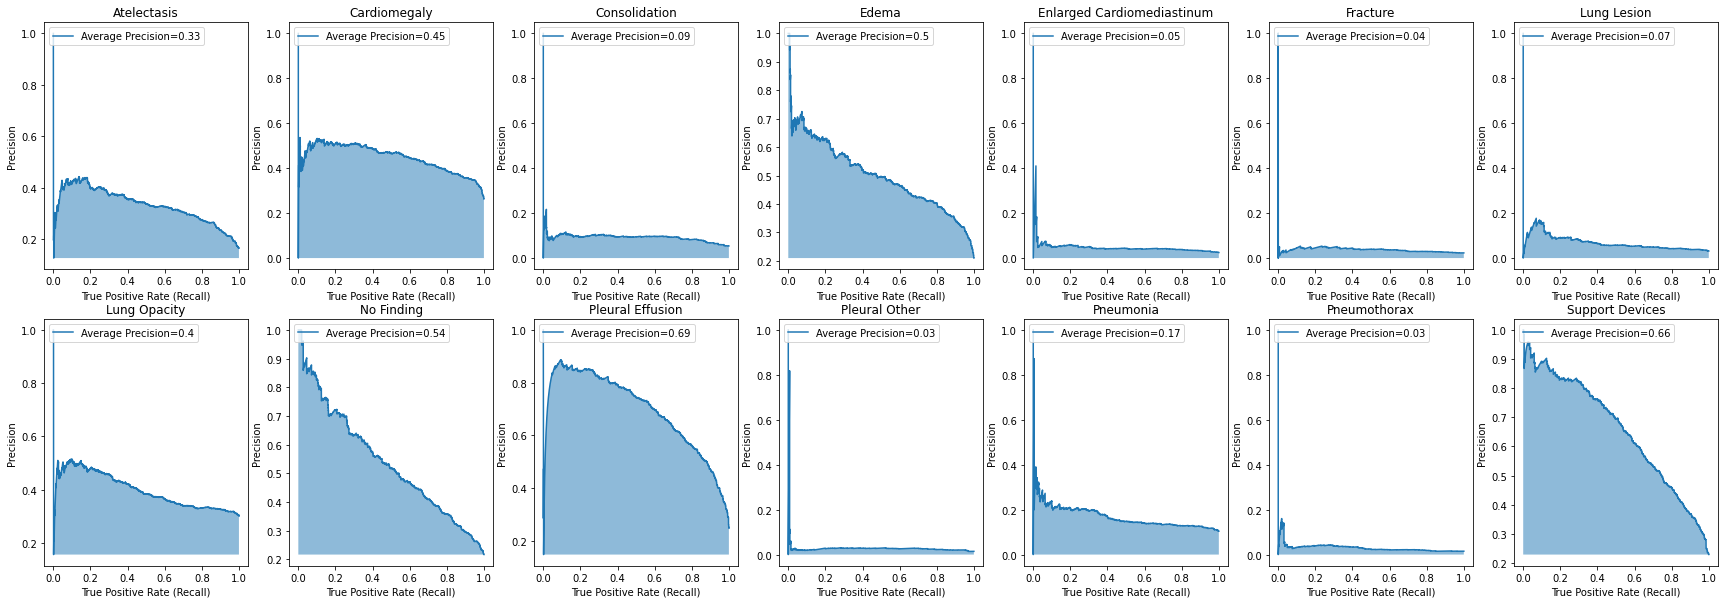

In [168]:
calc_auprc(results,labels)

The AUPRC curves and overall APC indicate that the model does perform worse on certain diagnosis labels, such as Pleural Other, Enlarged Cardiomediastinum, Fracture, Lung Lesion and Pneumothorax. 

## Stratification

We will be stratifying our analysis of the model by a few different relevant features, including race, sex, insurance status (Medicare, Medicaid, Private), ICU status and age.

### 1. Race

#### Pre-Processing

First, we can look at the racial categorization schema of the MIMIC database. We can see that the MIMIC database does not align with US Census categories on race, and includes more specific information on ethnicity. We can also see that white people are heavily overrepresented in the database. 

In [6]:
results['race'].value_counts()

WHITE                                 51823
BLACK/AFRICAN AMERICAN                18733
HISPANIC/LATINO - PUERTO RICAN         7018
HISPANIC OR LATINO                     3989
BLACK/CAPE VERDEAN                     2821
OTHER                                  2016
ASIAN - SOUTH EAST ASIAN               1579
ASIAN - ASIAN INDIAN                   1378
WHITE - EASTERN EUROPEAN               1332
WHITE - OTHER EUROPEAN                 1176
BLACK/CARIBBEAN ISLAND                 1102
ASIAN - CHINESE                        1096
WHITE - RUSSIAN                         421
AMERICAN INDIAN/ALASKA NATIVE           336
SOUTH AMERICAN                          296
PATIENT DECLINED TO ANSWER              202
MULTIPLE RACE/ETHNICITY                 175
HISPANIC/LATINO - CENTRAL AMERICAN      108
UNKNOWN                                  80
HISPANIC/LATINO - GUATEMALAN             68
PORTUGUESE                               34
UNABLE TO OBTAIN                         17
HISPANIC/LATINO - DOMINICAN     

This is why we can bucket the races. This will prevent some buckets, particularly of minority patients, of being too small relative to the number of white patients and will also facilitate our data analysis process. The buckets we will choose are:

    * White
    * Asian + Pacific Islander 
    * Hispanic/Latino
    * Black/African American
    * Unknown/Other (including Native American/American Indian, Multiple Ethnicites, Patient Declined to Specify)

In [10]:
# bucket races
def label_races(row):
    if row['race'] in ['BLACK/AFRICAN AMERICAN', 'BLACK/CAPE VERDEAN', 'BLACK/CARIBBEAN ISLAND']:
        return 'black'
    if row['race'] in ['WHITE', 'WHITE - OTHER EUROPEAN', 'WHITE - EASTERN EUROPEAN', 'WHITE - RUSSIAN', 'PORTUGUESE']:
        return 'white'
    if row['race'] in ['HISPANIC OR LATINO', 'HISPANIC/LATINO - CENTRAL AMERICAN', 'HISPANIC/LATINO - GUATEMALAN', 'HISPANIC/LATINO - PUERTO RICAN', 'HISPANIC/LATINO - DOMINICAN', 'SOUTH AMERICAN']:
        return 'hispanic/latino'
    if row['race'] in ['ASIAN - ASIAN INDIAN', 'ASIAN - KOREAN', 'ASIAN - CHINESE', 'ASIAN', 'ASIAN - SOUTH EAST ASIAN']:
        return 'asian'
    return 'other'

In [18]:
# distribution of new race buckets
results['race_bucket'] = results.apply(lambda row: label_races(row), axis=1)
results['race_bucket'].value_counts()

white              54786
black              22656
hispanic/latino    11495
asian               4063
other               2826
Name: race_bucket, dtype: int64

#### Evaluation

The first thing we will do is look at the distribution of records by race bucket for each of the 14 diagonses. This will help us get a better sense of what diagnoses are more commonly found in certain race buckets. 

*It is important to note that there is a lot of literature both for and against the idea that American conceptions of race are actually linked to any kind of genetic variation that impacts health, or if race is simply a proxy for a confluence of socioeconomic factors that contribute to health disparities. This project will not presume either orientation/explanation, but will simply analyze correlations between the model diagnoses at hand and designated Census-backed racial categories.*

In [60]:
# filter on relevant rows
race_dist_df = results.filter(['subject_id', 'race_bucket', 'Atelectasis', 'Cardiomegaly',
       'Consolidation', 'Edema', 'Enlarged Cardiomediastinum',
       'Fracture', 'Lung Lesion', 'Lung Opacity',
       'No Finding', 'Pleural Effusion', 'Pleural Other',
       'Pneumonia', 'Pneumothorax', 'Support Devices' ], axis=1)

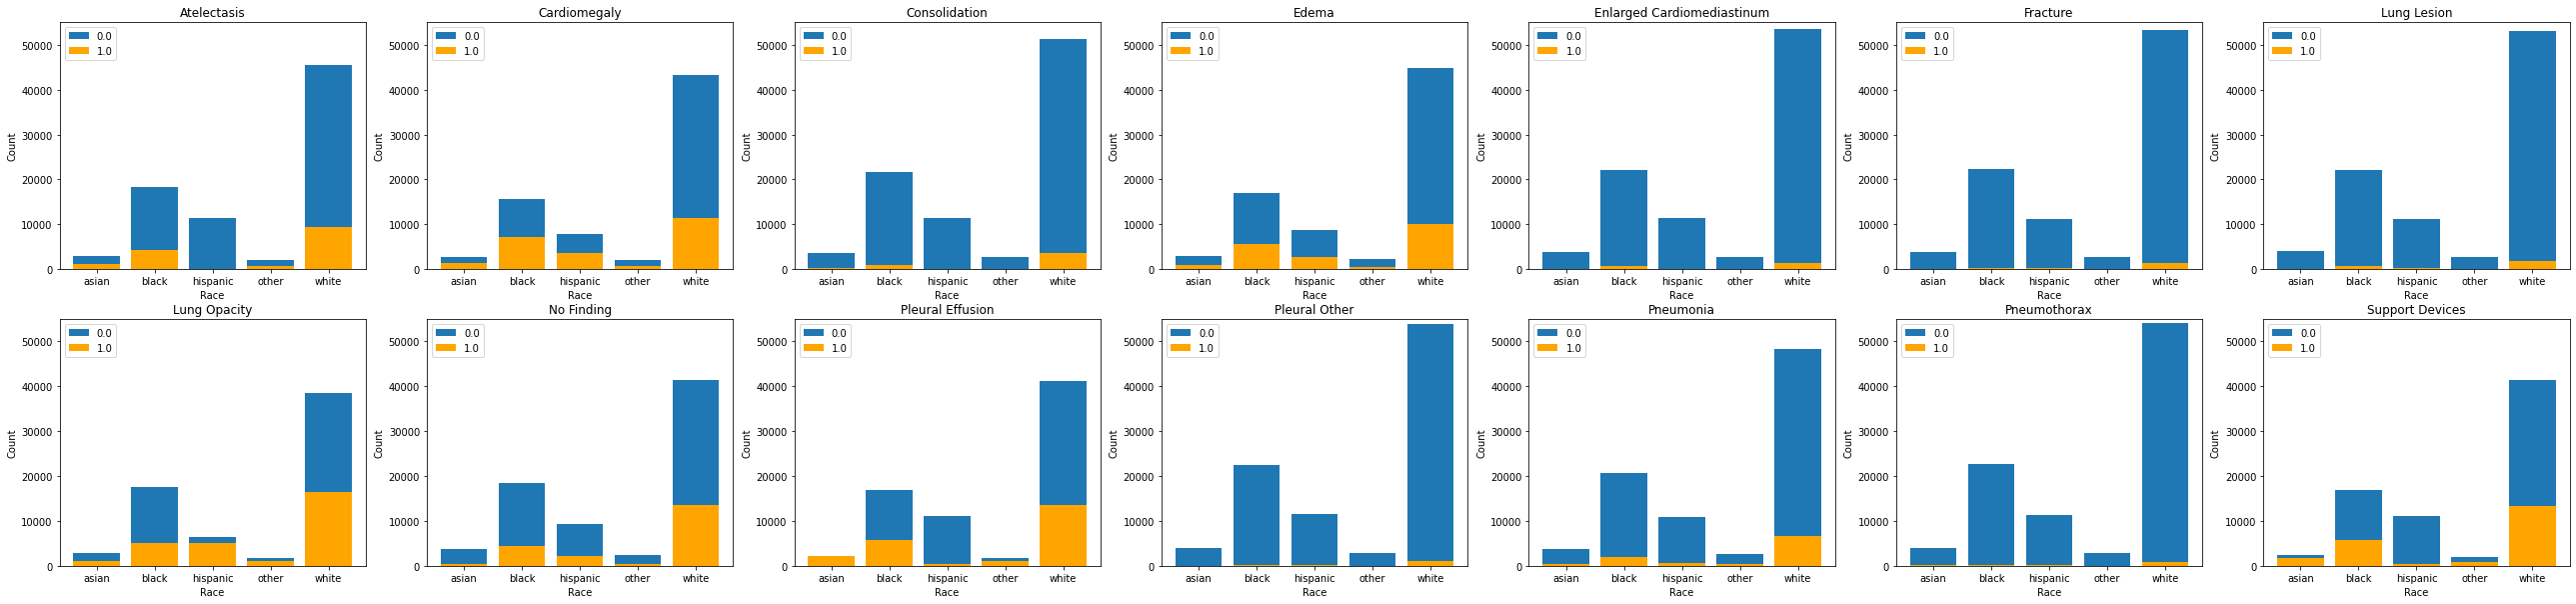

In [138]:
from matplotlib import ticker
fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(45, 10))
races = ['asian', 'black', 'hispanic', 'other', 'white']
positions = [0,1,2,3,4]
for i, lab in enumerate(labels):
    if i < 7:
        x = 0
    else:
        x = 1
    if i < 7:
        y = i
    else:
        y = i - 7

    a = pd.DataFrame({'count': race_dist_df.groupby([lab, 'race_bucket']).size()}).reset_index()
    neg_df = a[a[lab] == 0.0].iloc[:, 1:]
    pos_df = a[a[lab] == 1.0].iloc[:, 1:]
    ax[x,y].bar(neg_df.iloc[:,0], neg_df.iloc[:,1], label='0.0')
    ax[x,y].bar(pos_df.iloc[:,0], pos_df.iloc[:,1], color='orange', label='1.0')
    ax[x, y].title.set_text(lab)
    ax[x, y].legend(loc=2)
    ax[x, y].xaxis.set_major_locator(ticker.FixedLocator(positions))
    ax[x, y].xaxis.set_major_formatter(ticker.FixedFormatter(races))
    ax[x, y].set_xticklabels(races)
    ax[x, y].set_xlabel('Race')
    ax[x, y].set_ylabel('Count')
    ax[x, y].set_ylim(0,55000)
    

The next think we can do is look at the AUROC for each race-diagnosis combination, resulting in a multi-line plot for each diagnosis label.

In [169]:
# Helper functions for evaluating model performance
# Generate 95% Confidence Intervals for each AUC score
def generate_CI(y_true, y_pred):

    n_bootstraps = 1000
    rng_seed = 2021  
    bootstrapped_scores = []

    rng = np.random.RandomState(rng_seed)
    for i in range(n_bootstraps):
        indices = rng.randint(0, len(y_pred), len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            continue

        score = roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    #95% confidence interval
    confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    ci_str = '[{}, {}]'.format(str(round(confidence_lower, 3)), str(round(confidence_upper, 3)))
    return ci_str

# Calculate and plot ROC
def calc_roc(df, strata, labels):
    fpr = {}
    tpr = {}
    auc = {}
    fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(30, 10))
    for i, lab in enumerate(labels):
        if i < 7:
            x = 0
        else:
            x = 1
        if i < 7:
            y = i
        else:
            y = i - 7
        otpr, ofpr, _, = roc_curve(df[lab], df['pred_'+lab])
        oauc = roc_auc_score(df[lab], df['pred_'+lab])
        ci = generate_CI(df[lab], df['pred_'+lab])
        ax[x, y].plot(otpr, ofpr, label=f'Overall auc={round(oauc, 2)} ci={ci}')
        for category in df[strata].unique():
            tmp = df[df[strata] == category].reset_index(drop=True)
            ytrue = tmp[lab]
            ypred = tmp['pred_'+lab]
            tfpr, ttpr, _ = roc_curve(ytrue, ypred)
            tauc = roc_auc_score(ytrue, ypred)
            fpr[str(category) + '_' + lab] = tfpr
            tpr[str(category) + '_' + lab] = ttpr
            auc[str(category) + '_' + lab] = tauc
            tci = generate_CI(ytrue, ypred)
            ax[x, y].plot(tfpr, ttpr, label=f'{str(category)} auc={round(tauc, 2)}, ci={tci}')
            ax[x, y].title.set_text(lab)
            ax[x, y].legend(loc=4)
            ax[x, y].set_xlabel('FPR')
            ax[x, y].set_ylabel('TPR')

/local/scratch/zzaiman/CS334FinalProject/zach/niki-venv/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:951: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

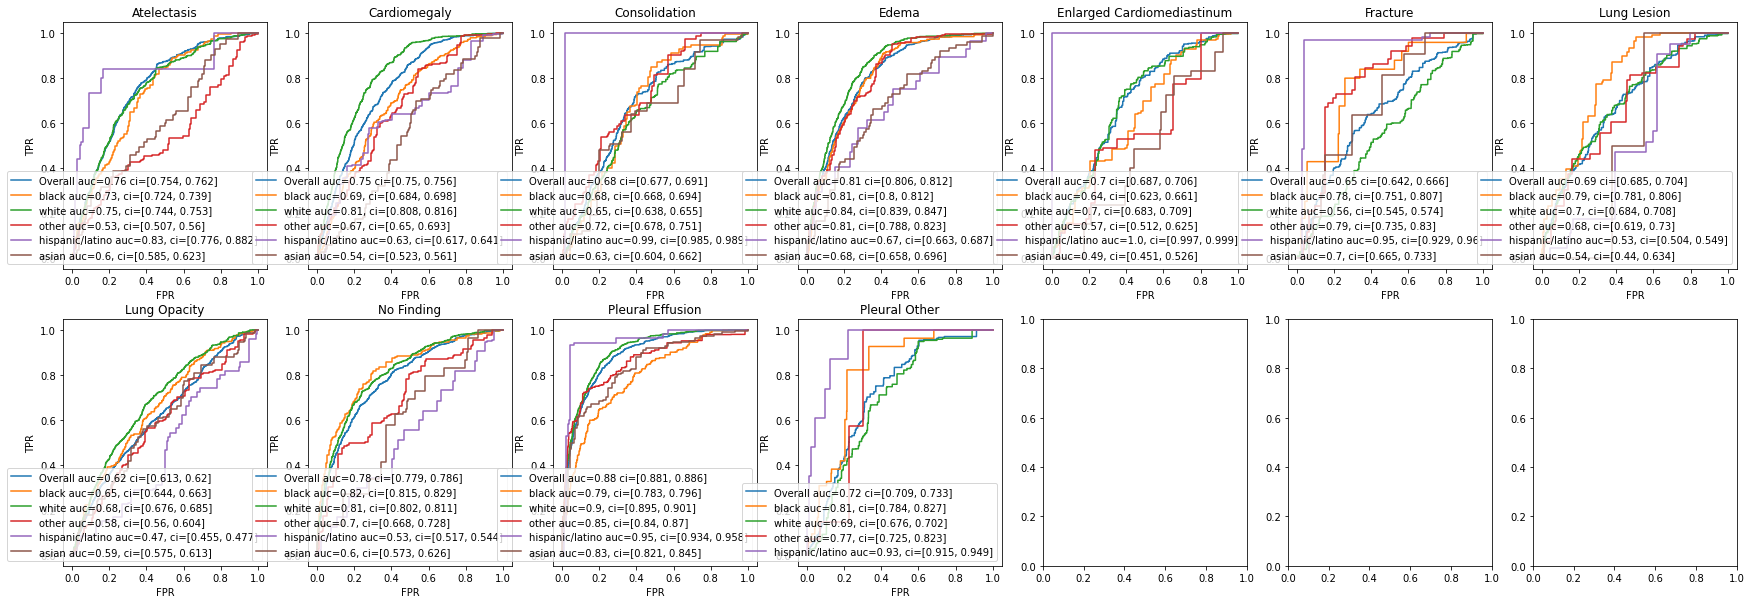

In [170]:
calc_roc(results, 'race_bucket', labels)

In [ ]:
# Nested Table showing model performance per race-diagnosis combination

### 2. ICU Status

Another feature we wanted to stratify by is the ICU status of the patient. Generally, patients who are in the ICU tend to have more severe diagnoses, so we wanted to see if the model would perform better on ICU patients' x-rays compared to non-ICU patients.

In [ ]:
icu = pd.read_csv('/home/zzaiman/local/physionet.org/files/mimiciv/2.0/icu/icustays.csv')
metadata = pd.read_csv('../../../physionet.org/files/mimic-cxr-jpg/2.0.0/mimic-cxr-2.0.0-metadata.csv')

In [ ]:
# Filter metadata to get StudyDate
metadata = metadata[['subject_id', 'study_id', 'StudyDate']]

# Convert dates to datetime. 
metadata['StudyDate'] = pd.to_datetime(metadata['StudyDate'], format='%Y%m%d')
icu['intime'] = pd.to_datetime(icu['intime'])
icu['outtime'] = pd.to_datetime(icu['outtime'])

# Merge with ICU and filter for all study dates in an ICU stay for the same patient.
metadata_icu = metadata.merge(icu, on='subject_id')
metadata_icu = metadata_icu[(metadata_icu['StudyDate'] >= metadata_icu['intime']) & (metadata_icu['StudyDate'] <= metadata_icu['outtime'])].reset_index(drop=True)


In [ ]:
metadata_icu.nunique()

In [ ]:
# Drop duplicates on study ID since all patients in this df are in the ICU.
metadata_icu = metadata_icu.drop_duplicates(subset=['study_id'])
metadata_icu.shape

In [ ]:
metadata_icu['study_in_icu'] = 1
metadata_icu_studies = metadata_icu[['study_id', 'study_in_icu']]
results_icu = results.merge(metadata_icu_studies, on='study_id', how='left')
results_icu['study_in_icu'].fillna(0, inplace=True)
results_icu['study_in_icu'].value_counts()

In [ ]:
calc_roc(results_icu, 'study_in_icu', labels)

We can also view the same result in table format, as seen below.

In [ ]:
cols = list(labels)
cat = list(labels)
groupby = 'study_in_icu'
tab = TableOne(results_icu, columns=cols, categorical=cat, groupby=groupby, missing=False, pval=True)